### **Step 1**

In this step, we explore the time series price data for the FTTS below.



1.   Equity -> SPDR S&P500 ETF (SPY)
2.   Fixed Income -> iShares 20+ Year Treasury Bond ETF (TLT)
3.   Cash-like -> iShares 1-3 Year Treasury Bond (SHY)
4.   Precious metal (Gold) -> SPDR Gold Shares (GLD)
5.   Crude Oil -> Invesco DB Oil Fund (DBO)



Our goal in this step is to understand the dynamics and characteristics of each of the time series.

**Gathering the data**

In this step we've defined the training period as price data from ***Jan 1, 2012 to December 31, 2016***.
This is avoid look ahead bais (peeking into the future) and give us enough past data to train the model on

We'll use data from ***Jan 1, 2017 to Dec 31, 2017*** as our validation set (which we will use for tuning) and ***Jan 1, 2018 to Dec 30, 2022*** as our test sample for out-of-sample assesment




In [227]:
# Getting the data
import yfinance as yf


# Defines the tickers whose data we are going to download
tickers = ["SPY", "TLT", "SHY", "GLD", "DBO"]

# Define the training, validation, and test sample
# periods

# Training sample period
train_start_date = "2013-01-01"
train_end_date = "2016-12-31"

# Validation sample period
val_start_date = "2017-01-01"
val_end_date = "2017-12-31"

# Test sample period
test_start_date = "2018-01-01"
test_end_date = "2022-12-30"

# Downloading the data
def download_data(tickers, start_date, end_date):
    """Return data frame with Adj Closing Prices"""
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=False
    )[['Adj Close']]
    return data

train = download_data(tickers, start_date=train_start_date, end_date=train_end_date)
val = download_data(tickers, start_date=val_start_date, end_date=val_end_date)
test = download_data(tickers, start_date=test_start_date, end_date=test_end_date)

# Flatten the MultiIndex and rename columns to just the ETF names
train.columns = train.columns.droplevel(0)  # Remove the 'Adj Close' level
val.columns = val.columns.droplevel(0)      # Remove the 'Adj Close' level
test.columns = test.columns.droplevel(0)    # Remove the 'Adj Close' level

# Now the column names are just the ETF names (e.g., 'SPY', 'TLT', etc.)
print(train.head())

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed

Ticker            DBO         GLD        SHY         SPY        TLT
Date                                                               
2013-01-02  23.022827  163.169998  71.381950  117.978676  87.002739
2013-01-03  22.952608  161.199997  71.381950  117.712128  85.823898
2013-01-04  22.970165  160.440002  71.390358  118.229057  86.158669
2013-01-07  23.014048  159.429993  71.390358  117.905998  86.195030
2013-01-08  23.075489  160.559998  71.398788  117.566765  86.762573


**Visualizing the price time series to get a sense of the price evolution of each of the ETFS**

We'll perform the EDA on the training sample to avoid look-ahead bias\

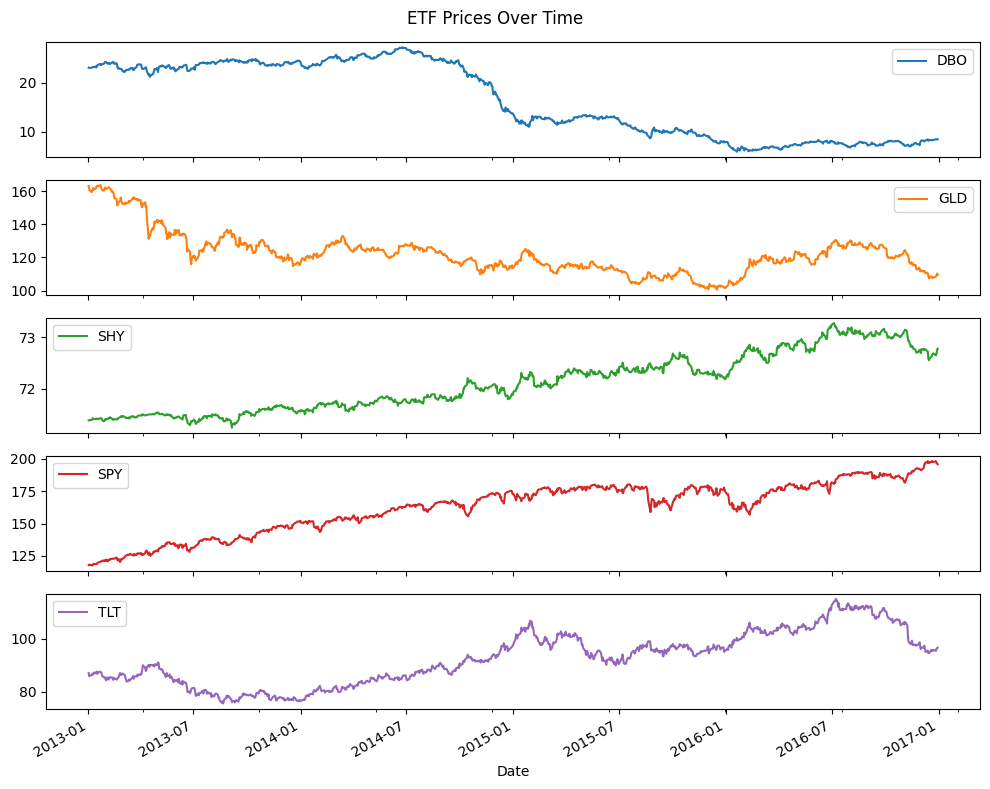

In [228]:
import matplotlib.pyplot as plt

train.plot(
    subplots=True,
    figsize=(10,8),
    layout=(len(train.columns), 1),
    sharex=True,
    title= "ETF Prices Over Time"
)
plt.tight_layout()
plt.show()



*   DBO(Oil) and GLD(Gold) both exhibit a downward trend while.
*   SPY (S&P 500) and SHY (Short-term Treasuries) exhibit an upward trend
*   TLT (Long-Term Treasuries) also exhibits moderate upward trend



**Visualizing the returns of time series to get a sense of the volatiltiy of each of the ETFS**

We'll use the training sample to avoid look-ahead bias

array([[<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>]], dtype=object)

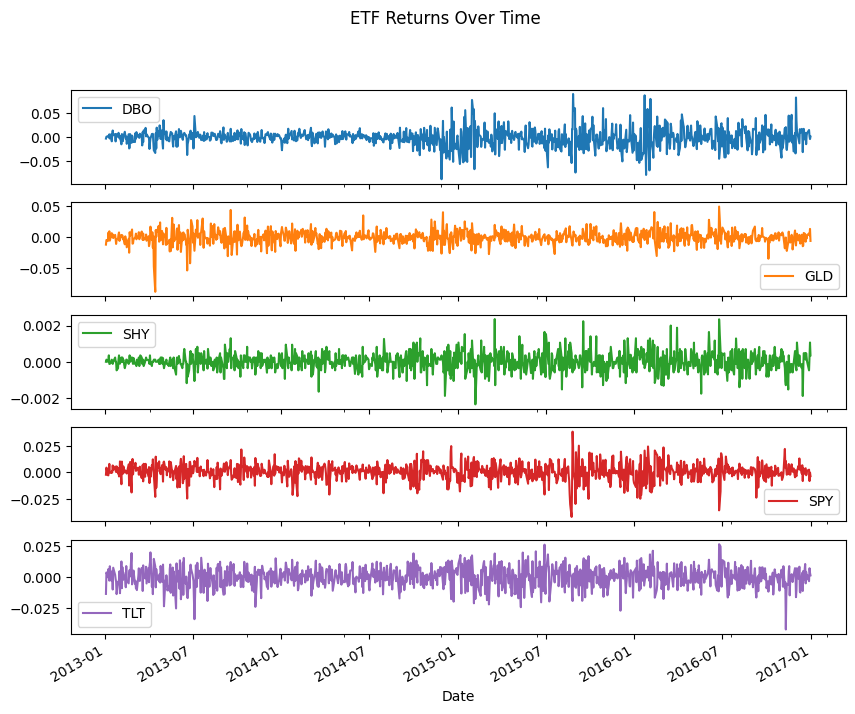

In [229]:
import matplotlib.pyplot as plt

# Compute the daily returns
returns = train.pct_change().dropna()

# Plot the returns
returns.plot(
    subplots = True,
    figsize=(10,8),
    layout=(len(returns.columns),1),
    sharex=True,
    title="ETF Returns Over Time"
)

* DBO (Oil) shows relatively large swings (returns can jump above +5% or below -5% at times). This indicates higher volatility in commodity markets.
* GLD (Gold) is somewhat volatile but tends to fluctuate within a smaller band than oil
* SHY (Short-Term Treasuries) is the least volatile; it's daily returns hover very close to zero.
* SPY (S&P 500) exhibits moderate volatility with daily returns typically within a ±2% range although there are occasional spikes
* TLT (Long-Term Treasureis) show more variablity than SHY

**Summary Statistics for daily returns**

In [230]:
returns_summary = returns.describe().T
returns_summary['skew'] = returns.skew()
returns_summary['kurtosis'] = returns.kurtosis()
returns_summary[['mean','std','skew','kurtosis']]

,mean,std,skew,kurtosis
Ticker,,,,
DBO,-0.000812,0.018858,0.143234,3.224638
GLD,-0.000338,0.010668,-0.528776,6.436091
SHY,0.000019,0.000523,0.138819,2.189806
SPY,0.000535,0.008040,-0.388928,2.362413
TLT,0.000139,0.008311,-0.341623,0.855661




**Volatility**
*   DBO(Oil) has the highest volatility shown by the high standard deviation. This confirms our earlier intuition from visualizing daily returns.
*   GLD(Gold), SPY(S&P 500) and TLT (Long-Term Treasuries) exhibit moderate volatility
*   SHY (Short-Term Treasuries) has the lowest volatility shown by the lowest standard deviation


**Returns Distribution**

* **Postive Skew Assets** show a tendecy towards large positive returns . Here we have DBO (Oil) and SHY (Short term securities)
* **Negative Skew Assets** are prone to sharper downshide moves. Here we have GLD (Gold), SPY (S&P 500) and TLT (Long Term Treasuries)
* **High kurtosis Assets** signal heavier tails and more frequent extreme outcomes. GLD (Gold) and DBO (Oil) has the high kurtosis in comparision to the other asset classes
* **Lower kurtosis Assets** for instance TLT (Long Term Treasuries),  imply fewer outlier and more stable returns

### **Step 2**

In Step 2, we are going to build an LSTM architecture via PyTorch and use this architecture to forecast 25 day forward returns for our 5 ETFs.

In [231]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

We first create $25$ day ahead returns to be used as our **targets**. Then, we construct $50$ day past returns as our **features**. We are going to use these past returns to predict our **targets**.

In [232]:
import numpy as np
import pandas as pd

def calculate_cumulative_returns(data, horizon=25):
    """
    Calculate the cumulative returns over the next `horizon` days.
    """
    # Calculate daily returns
    daily_returns = data.pct_change()
    
    # Calculate cumulative returns using (1 + returns).cumprod() - 1
    cumulative_returns = (1 + daily_returns).rolling(horizon).apply(lambda x: x.prod() - 1, raw=True)
    
    # Shift cumulative returns to align with the current day
    cumulative_returns = cumulative_returns.shift(-horizon)
    
    return cumulative_returns

train_returns = calculate_cumulative_returns(train)
val_returns = calculate_cumulative_returns(val)
test_returns = calculate_cumulative_returns(test)

# Drop NaN values from returns and align data
train = train.iloc[:len(train_returns.dropna())]
train_returns = train_returns.dropna()

val = val.iloc[:len(val_returns.dropna())]
val_returns = val_returns.dropna()

test = test.iloc[:len(test_returns.dropna())]
test_returns = test_returns.dropna()

# Create sequences of past returns
def create_sequences(data, returns, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(returns.iloc[i+seq_length])
    return np.array(X), np.array(y)



seq_length = 50
X_train, y_train = create_sequences(train, train_returns, seq_length)
X_val, y_val = create_sequences(val, val_returns, seq_length)
X_test, y_test = create_sequences(test, test_returns, seq_length)

# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (933, 50, 5), y_train shape: (933, 5)
X_val shape: (176, 50, 5), y_val shape: (176, 5)
X_test shape: (1183, 50, 5), y_test shape: (1183, 5)


As expected, we have $933$ timestep feature vectors where each of them have $50$ past returns data, for $5$ different ETFs.

Also for our **targets** dataset $y$, we have $933$ targets for each of the $5$ ETFs.

Then, we move on to **standardize** our data and load our datasets into *torch* tensor and DataLoader objects.

In [233]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Next, we define the LSTM model architecture for training and then summarize our architecture using **torchinfo** module.

In [234]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = X_train.shape[2]
hidden_size = 100
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
from torchinfo import summary
summary(model, input_size=(32, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─LSTM: 1-1                              [32, 50, 100]             123,600
├─Linear: 1-2                            [32, 1]                   101
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 197.76
Input size (MB): 0.03
Forward/backward pass size (MB): 1.28
Params size (MB): 0.49
Estimated Total Size (MB): 1.81

Then, we proceed to training our model for each ticker separately. We once again use **Adam** as our optimizer and **MSE** as our loss function. Our loss function is appropriate because we have a regression problem at hand.

While training, we always keep track of the validation loss and after training is finished, we save the model with the <u>minimum validation loss</u>.

We also plot the *training loss* and *validation loss* to better understand our model's training.

Training model for SPY
Epoch [1/50], Train Loss: 0.0045, Val Loss: 0.0002
New best validation loss: 0.0002. Saving model weights.
Epoch [2/50], Train Loss: 0.0013, Val Loss: 0.0002
New best validation loss: 0.0002. Saving model weights.
Epoch [3/50], Train Loss: 0.0012, Val Loss: 0.0002
Epoch [4/50], Train Loss: 0.0011, Val Loss: 0.0005
Epoch [5/50], Train Loss: 0.0011, Val Loss: 0.0007
Epoch [6/50], Train Loss: 0.0011, Val Loss: 0.0005
Epoch [7/50], Train Loss: 0.0011, Val Loss: 0.0007
Epoch [8/50], Train Loss: 0.0011, Val Loss: 0.0013
Epoch [9/50], Train Loss: 0.0012, Val Loss: 0.0009
Epoch [10/50], Train Loss: 0.0011, Val Loss: 0.0004
Epoch [11/50], Train Loss: 0.0012, Val Loss: 0.0003
Epoch [12/50], Train Loss: 0.0011, Val Loss: 0.0007
Epoch [13/50], Train Loss: 0.0011, Val Loss: 0.0005
Epoch [14/50], Train Loss: 0.0011, Val Loss: 0.0007
Epoch [15/50], Train Loss: 0.0011, Val Loss: 0.0009
Epoch [16/50], Train Loss: 0.0011, Val Loss: 0.0004
Epoch [17/50], Train Loss: 0.0011, Val Los

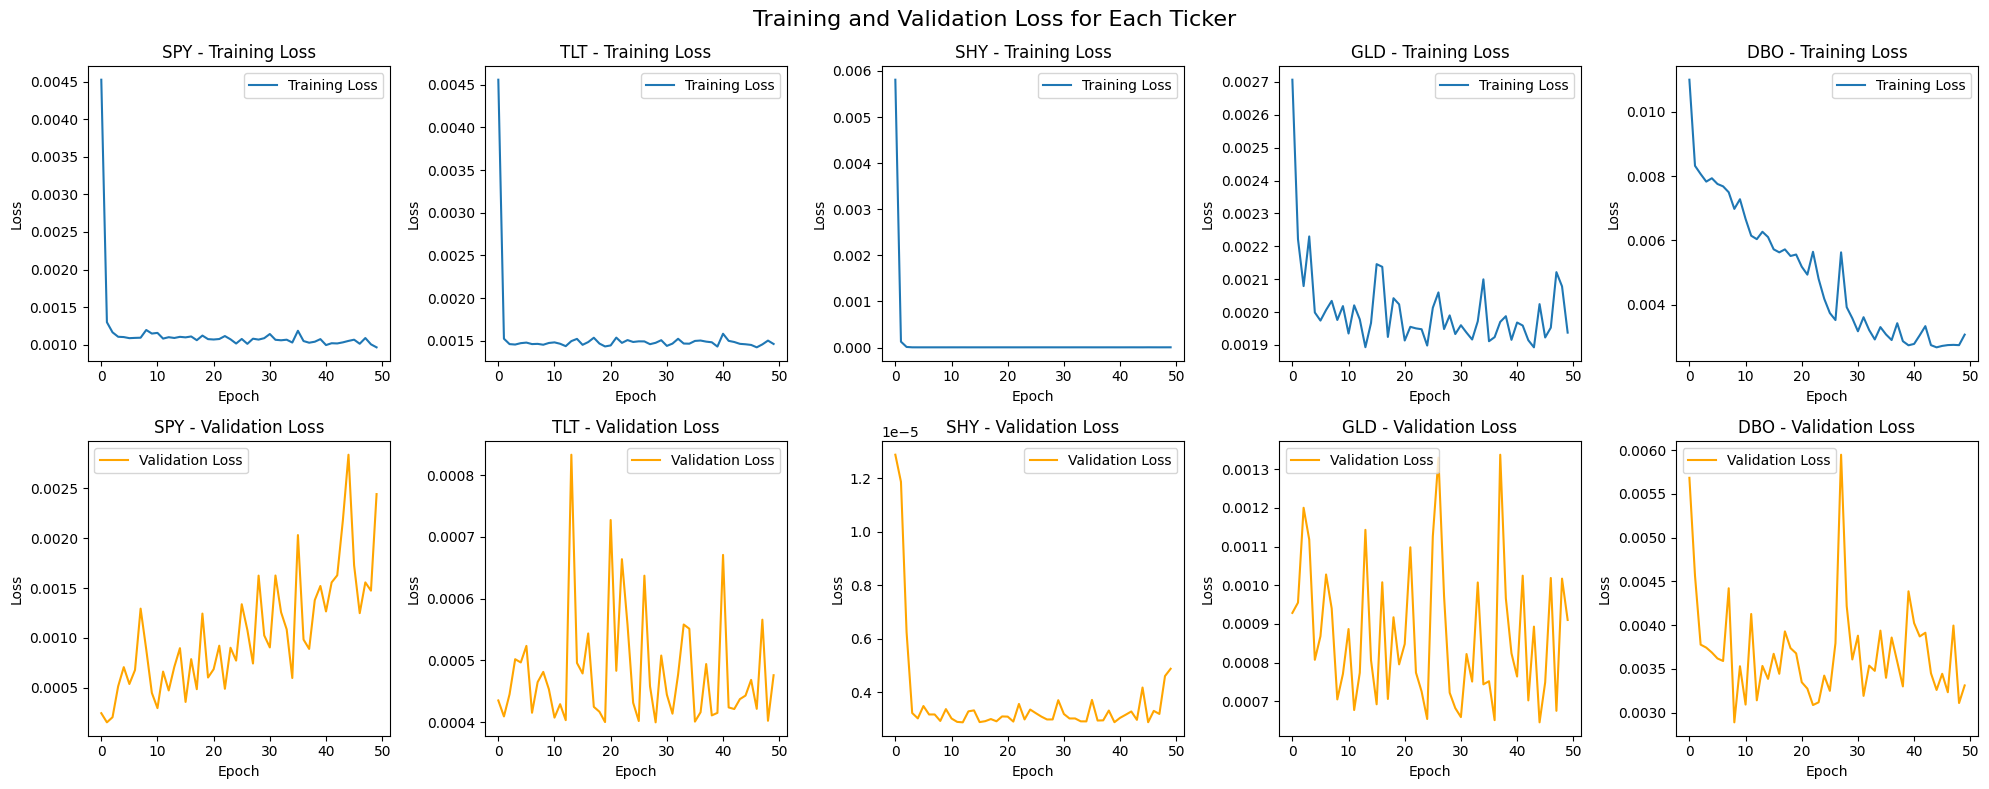

In [235]:
import matplotlib.pyplot as plt
import os

# Optimizer, loss function and num_epochs
num_epochs = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create a directory to save model weights
os.makedirs("model_weights", exist_ok=True)

# Initialize a 2x5 grid of subplots for training and validation loss
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Training and Validation Loss for Each Ticker", fontsize=16)

# Training loop for each ticker
for idx, ticker in enumerate(tickers):
    print(f'Training model for {ticker}')
    
    # Prepare data for the current ticker
    train_ticker = train[[ticker]]  # Access column directly using the ticker name
    val_ticker = val[[ticker]]      # Access column directly using the ticker name
    test_ticker = test[[ticker]]    # Access column directly using the ticker name
    
    # Calculate returns
    train_returns_ticker = calculate_cumulative_returns(train_ticker)
    val_returns_ticker = calculate_cumulative_returns(val_ticker)
    test_returns_ticker = calculate_cumulative_returns(test_ticker)
    
    # Drop NaN values from returns and align data
    train_ticker = train_ticker.iloc[:len(train_returns_ticker.dropna())]
    train_returns_ticker = train_returns_ticker.dropna()

    val_ticker = val_ticker.iloc[:len(val_returns_ticker.dropna())]
    val_returns_ticker = val_returns_ticker.dropna()

    test_ticker = test_ticker.iloc[:len(test_returns_ticker.dropna())]
    test_returns_ticker = test_returns_ticker.dropna()
    
    # Create sequences
    X_train_ticker, y_train_ticker = create_sequences(train_ticker, train_returns_ticker, seq_length)
    X_val_ticker, y_val_ticker = create_sequences(val_ticker, val_returns_ticker, seq_length)
    X_test_ticker, y_test_ticker = create_sequences(test_ticker, test_returns_ticker, seq_length)
    
    # Convert to PyTorch tensors
    X_train_ticker = torch.tensor(X_train_ticker, dtype=torch.float32)
    y_train_ticker = torch.tensor(y_train_ticker, dtype=torch.float32)
    X_val_ticker = torch.tensor(X_val_ticker, dtype=torch.float32)
    y_val_ticker = torch.tensor(y_val_ticker, dtype=torch.float32)
    X_test_ticker = torch.tensor(X_test_ticker, dtype=torch.float32)
    y_test_ticker = torch.tensor(y_test_ticker, dtype=torch.float32)
    
    # Create datasets and data loaders
    train_dataset_ticker = TimeSeriesDataset(X_train_ticker, y_train_ticker)
    val_dataset_ticker = TimeSeriesDataset(X_val_ticker, y_val_ticker)
    test_dataset_ticker = TimeSeriesDataset(X_test_ticker, y_test_ticker)
    
    train_loader_ticker = DataLoader(train_dataset_ticker, batch_size=32, shuffle=True)
    val_loader_ticker = DataLoader(val_dataset_ticker, batch_size=32, shuffle=False)
    test_loader_ticker = DataLoader(test_dataset_ticker, batch_size=32, shuffle=False)
    
    # Define model with input_size=1 for single ticker
    input_size = 1  # Only 1 feature (adjusted close price of the single ticker)
    hidden_size = 50
    num_layers = 2
    output_size = 1  # Predicting the 25-day ahead return

    model_ticker = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    
    # Define optimizer for the current model
    optimizer = torch.optim.Adam(model_ticker.parameters(), lr=0.001)
    
    # Initialize variables to track the best validation loss and corresponding model weights
    best_val_loss = float('inf')  # Start with a very high value
    best_model_weights = None
    
    # Lists to store training and validation losses for plotting
    train_losses = []
    val_losses = []
    
    # Train model
    for epoch in range(num_epochs):
        model_ticker.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader_ticker:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model_ticker(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Calculate average training loss for the epoch
        epoch_train_loss /= len(train_loader_ticker)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model_ticker.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader_ticker:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model_ticker(batch_X)
                val_loss += criterion(outputs, batch_y).item()
        val_loss /= len(val_loader_ticker)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Check if the current validation loss is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model_ticker.state_dict()  # Save the model's state dictionary
            print(f'New best validation loss: {best_val_loss:.4f}. Saving model weights.')
    
    # Save the best model weights to a file
    model_save_path = f"model_weights/best_model_weights_{ticker}.pth"
    torch.save(best_model_weights, model_save_path)
    print(f"Best model weights for {ticker} saved to {model_save_path}.")
    
    # Plot training and validation losses
    axes[0, idx].plot(train_losses, label="Training Loss")
    axes[0, idx].set_title(f"{ticker} - Training Loss")
    axes[0, idx].set_xlabel("Epoch")
    axes[0, idx].set_ylabel("Loss")
    axes[0, idx].legend()
    
    axes[1, idx].plot(val_losses, label="Validation Loss", color="orange")
    axes[1, idx].set_title(f"{ticker} - Validation Loss")
    axes[1, idx].set_xlabel("Epoch")
    axes[1, idx].set_ylabel("Loss")
    axes[1, idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

When we look into the training and validation loss plotting, we can see that our model's validation performance is best for the ticker **SHY**. For other tickers, validation performance seems lackluster.

Let us also look at the test performance of our model.

Evaluating model for SPY
Test Loss for SPY: 0.0081
Evaluating model for TLT
Test Loss for TLT: 0.0024
Evaluating model for SHY
Test Loss for SHY: 0.0000
Evaluating model for GLD
Test Loss for GLD: 0.0057
Evaluating model for DBO
Test Loss for DBO: 0.0176


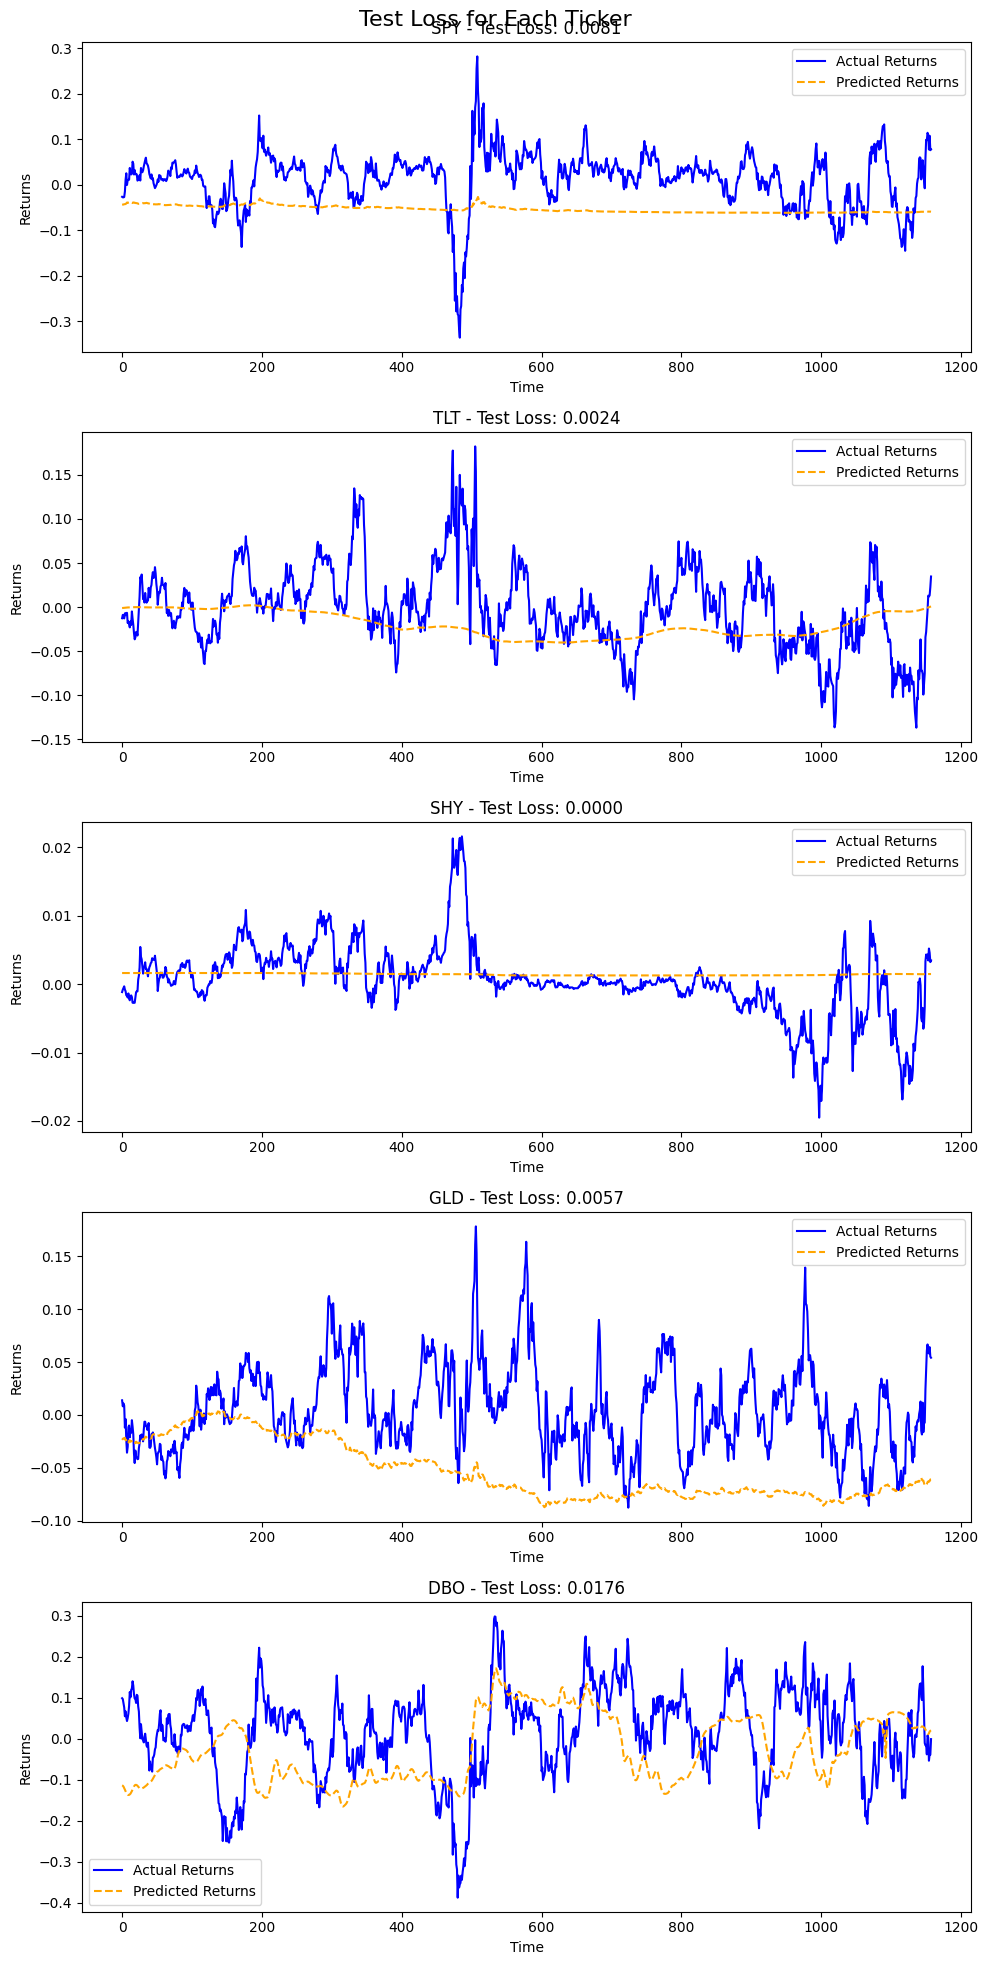

In [236]:
import matplotlib.pyplot as plt

# Initialize a figure to plot test loss for all tickers
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.suptitle("Test Loss for Each Ticker", fontsize=16)

# Test loop for each ticker
for idx, ticker in enumerate(tickers):
    print(f"Evaluating model for {ticker}")
    
    # Load the saved best model weights
    model_save_path = f"model_weights/best_model_weights_{ticker}.pth"
    model_ticker = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=1).to(device)
    model_ticker.load_state_dict(torch.load(model_save_path))
    model_ticker.eval()
    
    # Prepare test data for the current ticker
    test_ticker = test[[ticker]]  # Access column directly using the ticker name
    test_returns_ticker = calculate_cumulative_returns(test_ticker)
    
    # Drop NaN values from returns and align data
    test_ticker = test_ticker.iloc[:len(test_returns_ticker.dropna())]
    test_returns_ticker = test_returns_ticker.dropna()
    
    # Create sequences for test data
    X_test_ticker, y_test_ticker = create_sequences(test_ticker, test_returns_ticker, seq_length)
    
    # Convert to PyTorch tensors
    X_test_ticker = torch.tensor(X_test_ticker, dtype=torch.float32)
    y_test_ticker = torch.tensor(y_test_ticker, dtype=torch.float32)
    
    # Create dataset and data loader
    test_dataset_ticker = TimeSeriesDataset(X_test_ticker, y_test_ticker)
    test_loader_ticker = DataLoader(test_dataset_ticker, batch_size=32, shuffle=False)
    
    # Evaluate model on test data
    test_loss = 0
    predictions = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader_ticker:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_ticker(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
    
    # Calculate average test loss
    test_loss /= len(test_loader_ticker)
    print(f"Test Loss for {ticker}: {test_loss:.4f}")
    
    # Plot test loss
    axes[idx].plot(y_test_ticker.numpy(), label="Actual Returns", color="blue")
    axes[idx].plot(predictions, label="Predicted Returns", color="orange", linestyle="--")
    axes[idx].set_title(f"{ticker} - Test Loss: {test_loss:.4f}")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Returns")
    axes[idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Let us now create a trading strategy where we buy the ETF when the model forecasts more than **5%** return on the 25th day and sell it on that day. Otherwise, the strategy will have a flat position. We will run this strategy on our test set and then compare its performance to a simple buy-and-hold strategy.

Implementing trading strategy for SPY
Number of predictions > 1%: 0
Number of actual returns > 1%: 729
--------------------------------------------------
Implementing trading strategy for TLT
Number of predictions > 1%: 0
Number of actual returns > 1%: 442
--------------------------------------------------
Implementing trading strategy for SHY
Number of predictions > 1%: 0
Number of actual returns > 1%: 30
--------------------------------------------------
Implementing trading strategy for GLD
Number of predictions > 1%: 0
Number of actual returns > 1%: 487
--------------------------------------------------
Implementing trading strategy for DBO
Number of predictions > 1%: 451
Number of actual returns > 1%: 683
--------------------------------------------------


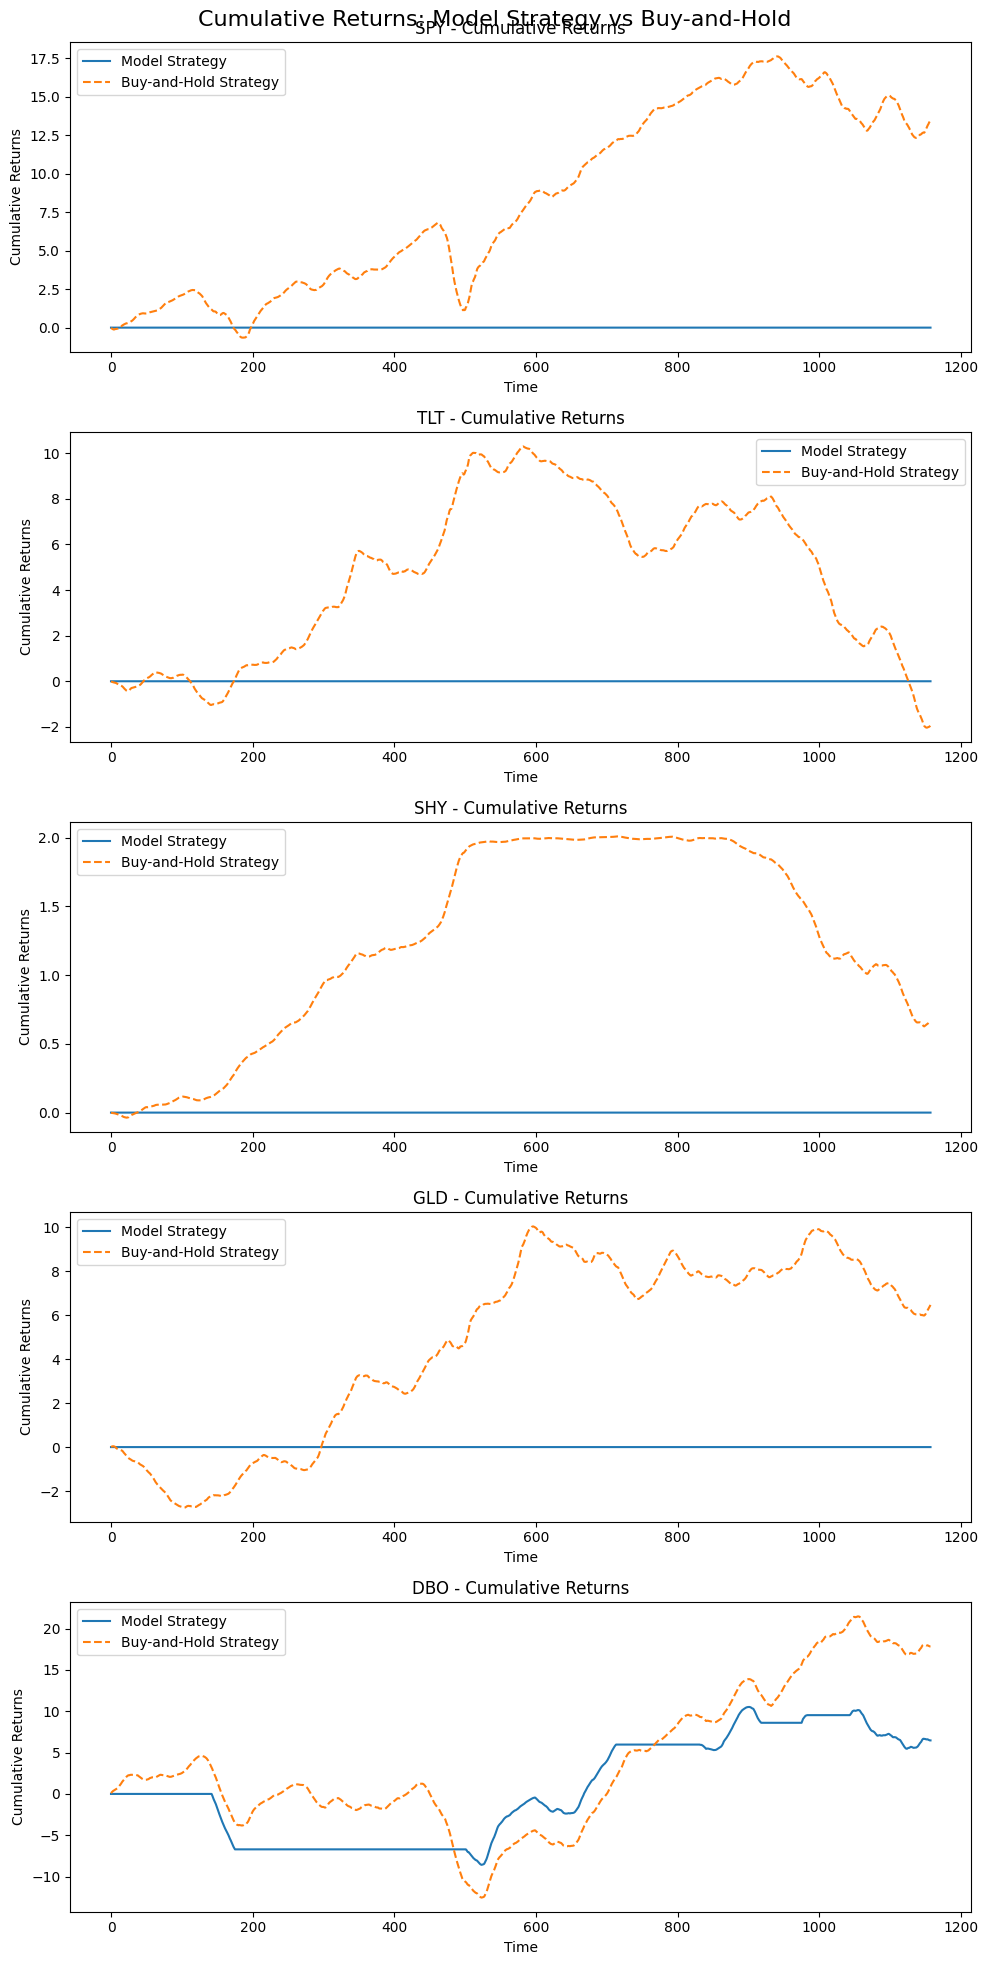

In [ ]:
buy_treshold = 0.01

# Initialize a figure to plot cumulative returns for all tickers
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# Trading strategy for each ticker
for idx, ticker in enumerate(tickers):
    print(f"Implementing trading strategy for {ticker}")
    
    # Load the saved best model weights
    model_save_path = f"model_weights/best_model_weights_{ticker}.pth"
    model_ticker = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=1).to(device)
    model_ticker.load_state_dict(torch.load(model_save_path))
    model_ticker.eval()
    
    # Prepare test data for the current ticker
    test_ticker = test[[ticker]]  # Access column directly using the ticker name
    test_returns_ticker = calculate_cumulative_returns(test_ticker)
    
    # Drop NaN values from returns and align data
    test_ticker = test_ticker.iloc[:len(test_returns_ticker.dropna())]
    test_returns_ticker = test_returns_ticker.dropna()
    
    # Create sequences for test data
    X_test_ticker, y_test_ticker = create_sequences(test_ticker, test_returns_ticker, seq_length)
    
    # Convert to PyTorch tensors
    X_test_ticker = torch.tensor(X_test_ticker, dtype=torch.float32)
    y_test_ticker = torch.tensor(y_test_ticker, dtype=torch.float32)
    
    # Create dataset and data loader
    test_dataset_ticker = TimeSeriesDataset(X_test_ticker, y_test_ticker)
    test_loader_ticker = DataLoader(test_dataset_ticker, batch_size=32, shuffle=False)
    
    # Generate predictions
    predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader_ticker:
            batch_X = batch_X.to(device)
            outputs = model_ticker(batch_X)
            predictions.extend(outputs.cpu().numpy())
    
    # Convert predictions to a numpy array
    predictions = np.array(predictions).flatten()

    print("Number of predictions > 1%:", np.sum(predictions > 0.01))
    
    # Trading strategy logic
    positions = []  # Track whether we are holding a position (1) or not (0)
    strategy_returns = []  # Track daily returns for the model strategy
    buy_and_hold_returns = []  # Track daily returns for the buy-and-hold strategy
    
    for i in range(len(predictions)):
        if i >= len(test_ticker) - seq_length:
            break  # Stop if we reach the end of the test data
        
        # Buy signal: Predicted cumulative return > 5%
        if predictions[i] > buy_treshold:
            positions.append(1)  # Buy and hold for 25 days
            strategy_returns.append(test_returns_ticker.iloc[i + seq_length, 0])  # Actual cumulative return after 25 days
        else:
            positions.append(0)  # No position
            strategy_returns.append(0)  # No return
        
        # Buy-and-hold strategy: Always hold the position
        buy_and_hold_returns.append(test_returns_ticker.iloc[i + seq_length, 0])
    
    # Calculate cumulative returns for the model strategy
    model_cumulative_returns = np.cumsum(strategy_returns)
    
    # Calculate cumulative returns for the buy-and-hold strategy
    buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_returns)

    print("Number of actual returns > 1%:", np.sum(test_returns_ticker.iloc[:, 0].values > 0.01))

    print("-"*50)
    
    # Plot cumulative returns
    axes[idx].plot(model_cumulative_returns, label="Model Strategy")
    axes[idx].plot(buy_and_hold_cumulative_returns, label="Buy-and-Hold Strategy", linestyle="--")
    axes[idx].set_title(f"{ticker} - Cumulative Returns")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Cumulative Returns")
    axes[idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

According to our strategy results, we can see that only acceptable performance has been in the ticker **DBO**. This might be because our models were **underfitting** in other tickers.

### **Step 3**

We now use the multivariate training for our LSTM architecture, where we train on $5 \times 50$ past returns together, and try to forecast $5 \times 1$ future cumulative 25-day returns.

Epoch [1/50], Train Loss: 0.0037, Val Loss: 0.0013
New best validation loss: 0.0013. Saving model weights.
Epoch [2/50], Train Loss: 0.0026, Val Loss: 0.0019
Epoch [3/50], Train Loss: 0.0024, Val Loss: 0.0024
Epoch [4/50], Train Loss: 0.0022, Val Loss: 0.0041
Epoch [5/50], Train Loss: 0.0022, Val Loss: 0.0074
Epoch [6/50], Train Loss: 0.0021, Val Loss: 0.0038
Epoch [7/50], Train Loss: 0.0019, Val Loss: 0.0040
Epoch [8/50], Train Loss: 0.0020, Val Loss: 0.0044
Epoch [9/50], Train Loss: 0.0019, Val Loss: 0.0036
Epoch [10/50], Train Loss: 0.0020, Val Loss: 0.0055
Epoch [11/50], Train Loss: 0.0019, Val Loss: 0.0064
Epoch [12/50], Train Loss: 0.0018, Val Loss: 0.0072
Epoch [13/50], Train Loss: 0.0018, Val Loss: 0.0049
Epoch [14/50], Train Loss: 0.0020, Val Loss: 0.0059
Epoch [15/50], Train Loss: 0.0018, Val Loss: 0.0045
Epoch [16/50], Train Loss: 0.0017, Val Loss: 0.0054
Epoch [17/50], Train Loss: 0.0017, Val Loss: 0.0044
Epoch [18/50], Train Loss: 0.0021, Val Loss: 0.0077
Epoch [19/50], Tr

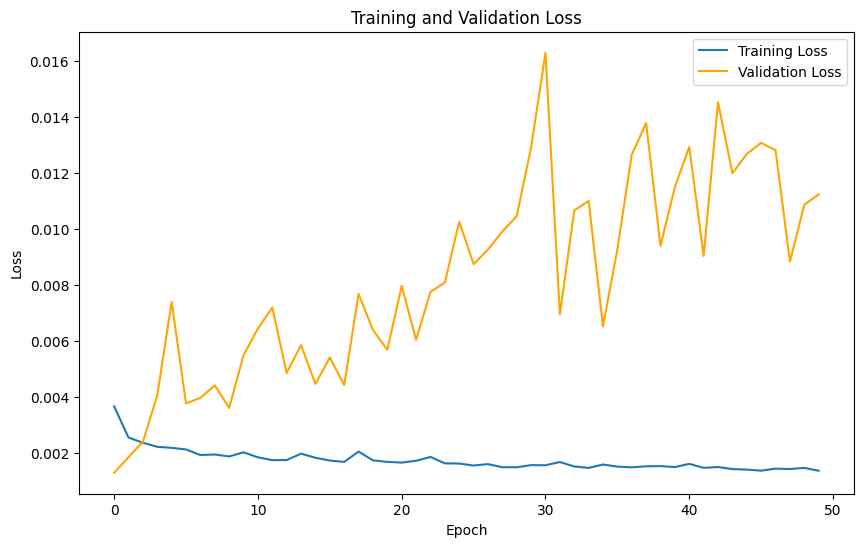

In [238]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the LSTM model for multivariate prediction
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the output of the last time step
        return out

# Define model hyperparameters
input_size = 5  # Number of tickers (features)
hidden_size = 50
num_layers = 2
output_size = 5  # Number of tickers (targets)

# Initialize the model
model = MultivariateLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create a directory to save model weights
os.makedirs("model_weights", exist_ok=True)

# Initialize variables to track the best validation loss and corresponding model weights
best_val_loss = float('inf')  # Start with a very high value
best_model_weights = None

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Check if the current validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()  # Save the model's state dictionary
        print(f'New best validation loss: {best_val_loss:.4f}. Saving model weights.')

# After training, load the best model weights
model.load_state_dict(best_model_weights)
print("Training complete. Best model weights loaded.")

# Save the best model weights to a file
model_save_path = "model_weights/best_model_weights_multivariate.pth"
torch.save(best_model_weights, model_save_path)
print(f"Best model weights saved to {model_save_path}.")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Although our model quickly converged in terms of training loss, if we look at the validation loss we can see that our model is not generalizable at all. This might be due to scaling of features or hyperparameter selection in our LSTM architecture.

Now let us again check our optimally-weighted model against the test dataset.

Test Loss: 0.0162


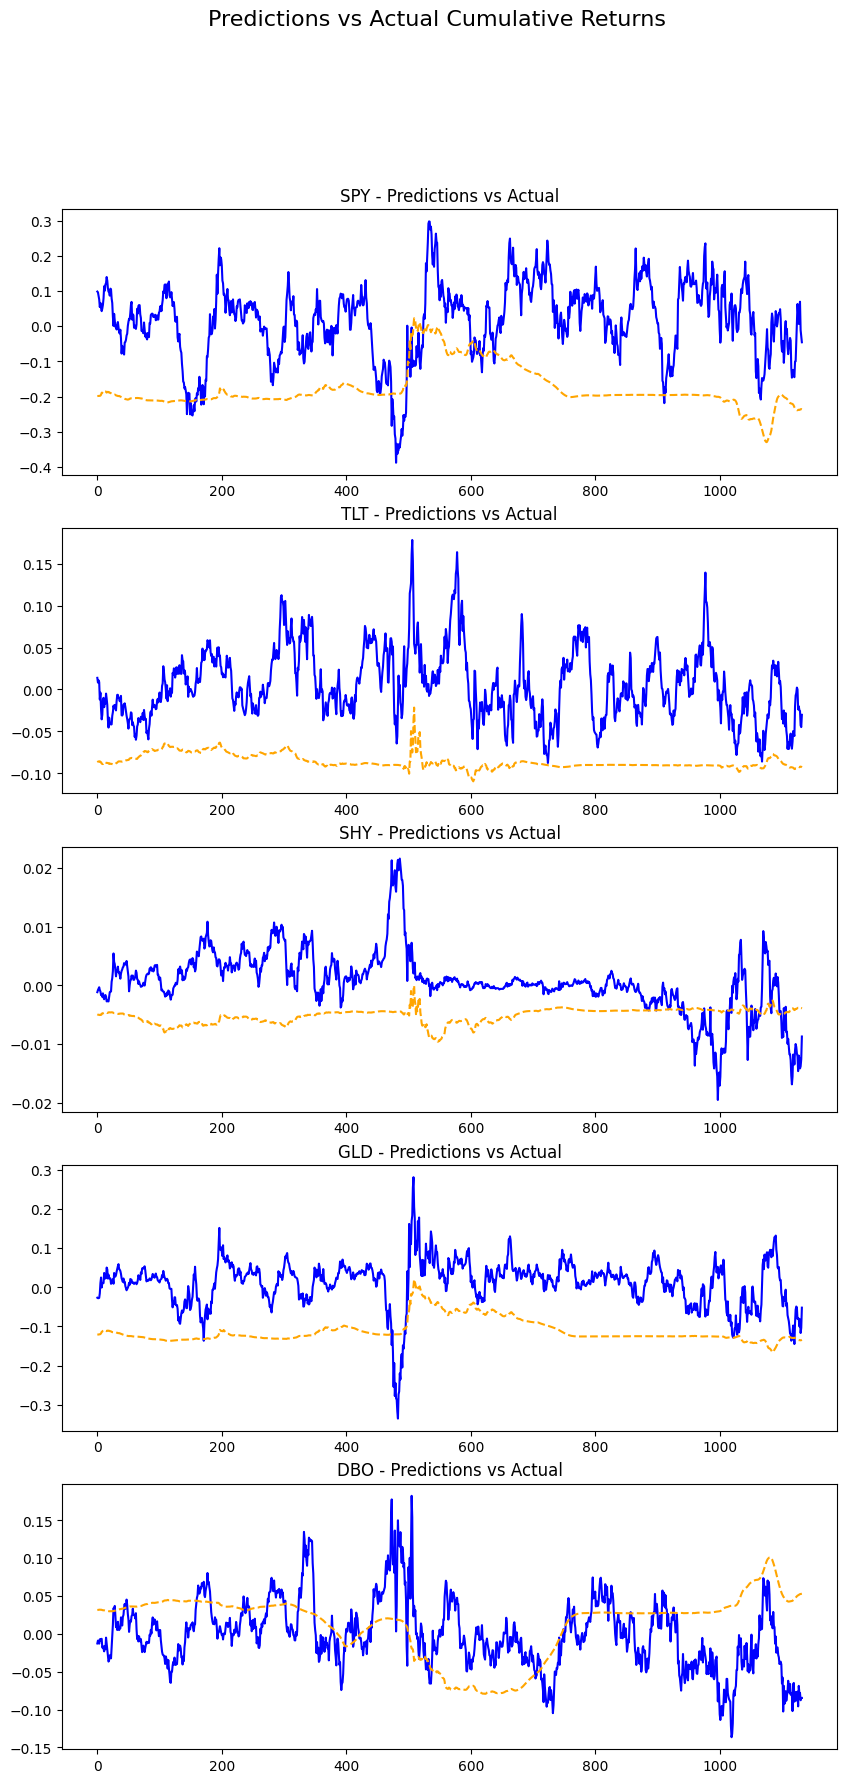

In [240]:
# Define the function to create multivariate sequences
def create_multivariate_sequences(data, returns, seq_length=50):
    """
    Create sequences of past data and corresponding cumulative returns for multivariate prediction.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Use all 5 tickers as features
        y.append(returns.iloc[i+seq_length].values)  # Use all 5 cumulative returns as targets
    return np.array(X), np.array(y)

# Load the saved best model weights
model_save_path = "model_weights/best_model_weights_multivariate.pth"
model = MultivariateLSTMModel(input_size=5, hidden_size=50, num_layers=2, output_size=5).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Prepare test data for all tickers
test_returns = calculate_cumulative_returns(test)

# Drop NaN values from returns and align data
test = test.iloc[:len(test_returns.dropna())]
test_returns = test_returns.dropna()

# Create sequences for test data
X_test, y_test = create_multivariate_sequences(test, test_returns, seq_length)

# Convert to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create dataset and data loader
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate model on test data
test_loss = 0
predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        predictions.extend(outputs.cpu().numpy())

# Calculate average test loss
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Plot predictions vs actual values for each ETF
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.suptitle("Predictions vs Actual Cumulative Returns", fontsize=16)

for idx, ticker in enumerate(tickers):
    axes[idx].plot(y_test[:, idx], label="Actual Returns", color="blue")
    axes[idx].plot(predictions[:, idx], label="Predicted Returns", color="orange", linestyle="--")
    axes[idx].set_title(f"{ticker} - Predictions vs Actual")

After we check our test data, let us build the multivariate trading strategy with a buy treshold of 1%.

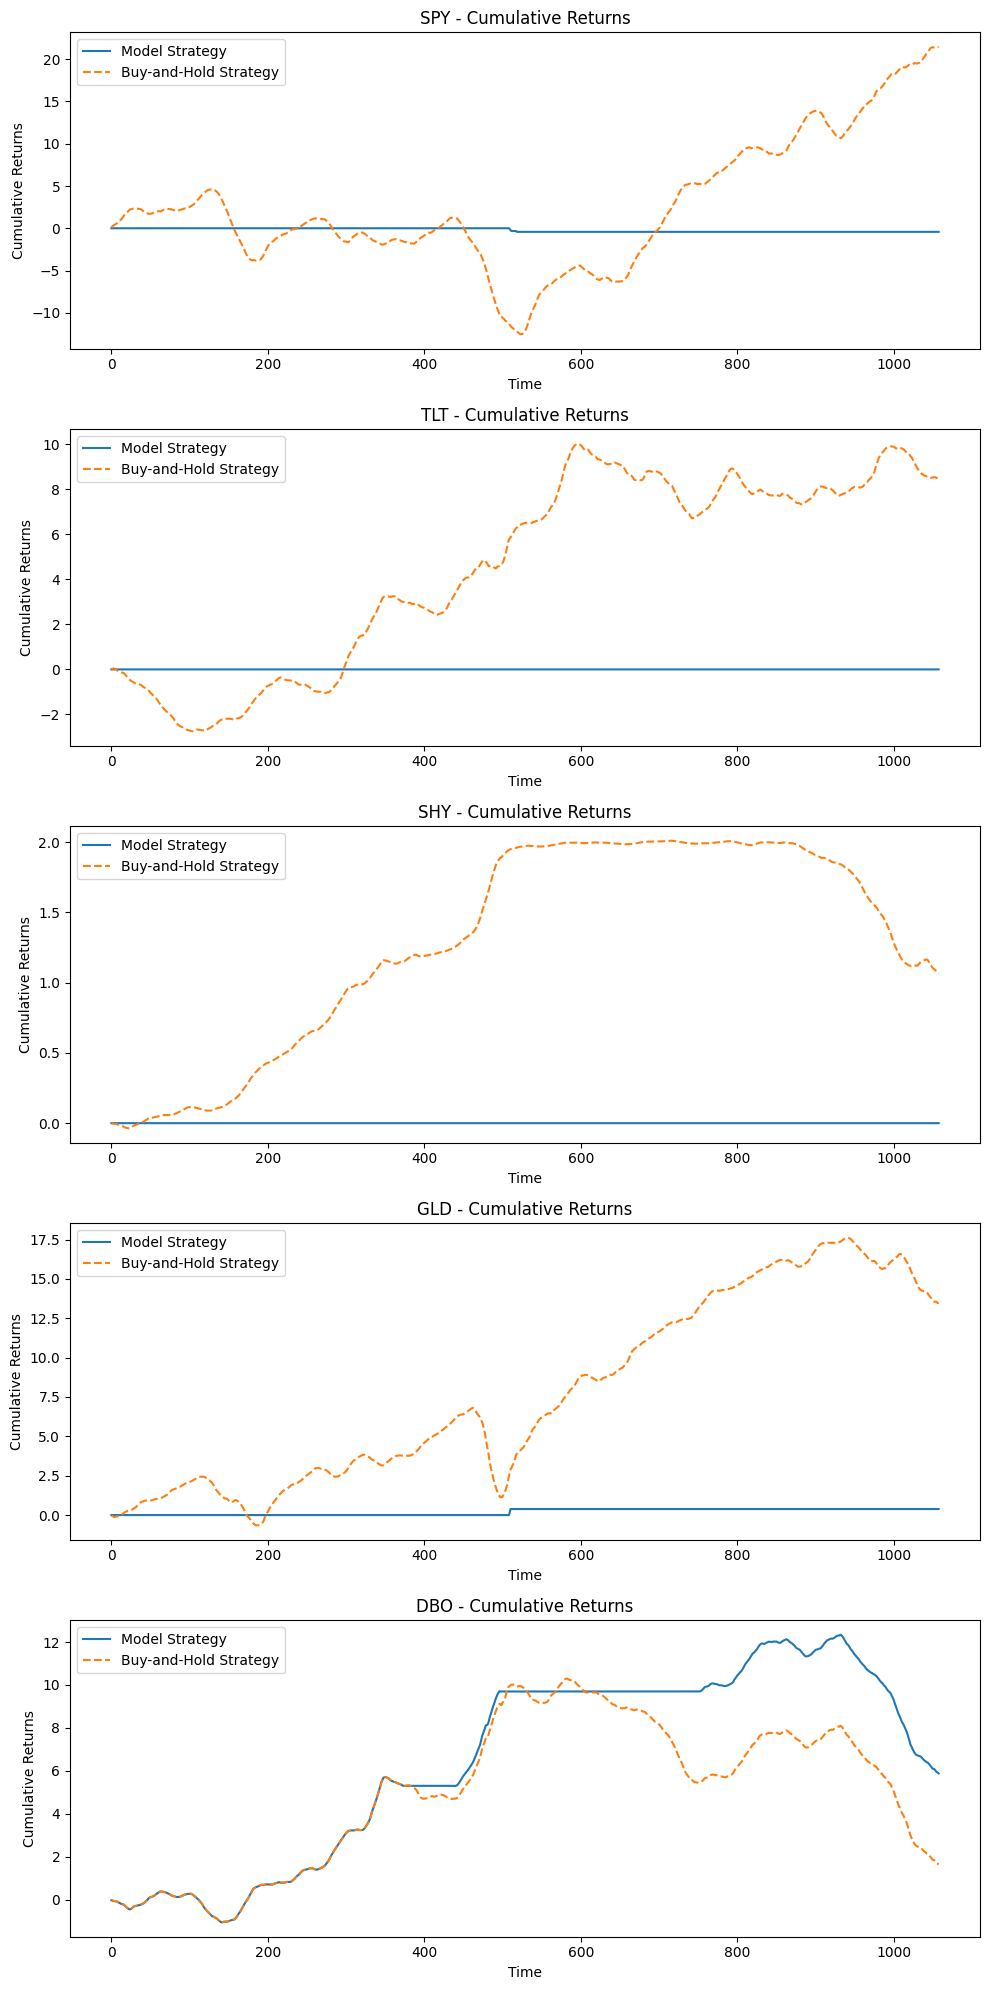

In [243]:
import matplotlib.pyplot as plt

# Define the buy threshold
buy_threshold = 0.01

# Load the saved best model weights
model_save_path = "model_weights/best_model_weights_multivariate.pth"
model = MultivariateLSTMModel(input_size=5, hidden_size=50, num_layers=2, output_size=5).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Prepare test data for all tickers
test_returns = calculate_cumulative_returns(test)

# Drop NaN values from returns and align data
test = test.iloc[:len(test_returns.dropna())]
test_returns = test_returns.dropna()

# Create sequences for test data
X_test, y_test = create_multivariate_sequences(test, test_returns, seq_length)

# Convert to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create dataset and data loader
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Generate predictions
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Trading strategy logic
positions = np.zeros((len(predictions), 5))  # Track positions for each ETF
strategy_returns = np.zeros((len(predictions), 5))  # Track returns for each ETF

for i in range(len(predictions)):
    if i >= len(test) - seq_length:
        break  # Stop if we reach the end of the test data
    
    for j in range(5):  # Loop through each ETF
        # Buy signal: Predicted cumulative return > buy_threshold
        if predictions[i, j] > buy_threshold:
            positions[i, j] = 1  # Buy and hold for 25 days
            strategy_returns[i, j] = test_returns.iloc[i + seq_length, j]  # Actual cumulative return after 25 days
        else:
            positions[i, j] = 0  # No position
            strategy_returns[i, j] = 0  # No return

# Calculate cumulative returns for the model strategy
model_cumulative_returns = np.cumsum(strategy_returns, axis=0)

# Equal-weight buy-and-hold strategy
buy_and_hold_returns = test_returns.iloc[seq_length:].values
buy_and_hold_cumulative_returns = np.cumsum(buy_and_hold_returns, axis=0)

# Plot cumulative returns for each ETF
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for idx, ticker in enumerate(tickers):
    axes[idx].plot(model_cumulative_returns[:, idx], label="Model Strategy")
    axes[idx].plot(buy_and_hold_cumulative_returns[:, idx], label="Buy-and-Hold Strategy", linestyle="--")
    axes[idx].set_title(f"{ticker} - Cumulative Returns")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Cumulative Returns")
    axes[idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()